# Modeling Gut Reporters

Below we will attempt to model the shedding of gut biosensors, as introduced by Kotula et al. in their 2004 PNAS paper. Specifically, we are interested in the usage of 


In [2]:
from math import *
from time import time
from datetime import timedelta
from random import random
import numpy as np
#Sympy
from sympy import *
%matplotlib inline
from IPython.display import display
init_printing()
#visualization
from ipywidgets import interact
from bokeh.io import push_notebook, show, output_notebook
from bokeh.plotting import figure
from bokeh.models import Legend
output_notebook()

Loading BokehJS ...

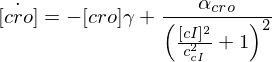

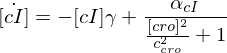

In [39]:
cro, cI, a_cro, a_cI, c_cro, c_cI, gamma, t = symbols("[cro] [cI] alpha_cro alpha_cI c_cro c_cI gamma t", positive=1)
dot_cro = a_cro/(1+(cI/c_cI)**2)**2 - gamma*cro
dot_cI = a_cI/(1+(cro/c_cro)**2) - gamma*cI
display(Eq(Symbol("\dot{[cro]}"), dot_cro), Eq(Symbol("\dot{[cI]}"), dot_cI))

In [51]:
alpha_cro=.04
alpha_cI=.09
rep_cro=4
rep_cI=4
subs_cro = dot_cro.subs([(a_cro, alpha_cro), (c_cI, rep_cI), (gamma, .001)])
subs_cI = dot_cI.subs([(a_cI, alpha_cI), (c_cro, rep_cro), (gamma, .004)])
#plot(subs_cI, (cro, 0, 40))
#plot(subs_cro, (cI, 0, 40))

In [52]:
class Cell:
    def __init__(self, plot_name=None, stochastic=0, continuous_plotting=1):
        self.stochastic = stochastic; #bool indicating whether stochasticity should be modeled
        self.age = 0; #seconds
        self.proteins = {"cro": 2, "cI": 25}
        self.history = {"age": [], "cro": [], "cI": []}
        self.repr_time = 60*60; #seconds
        #Prepping for plotting
        self.plot = figure(title=plot_name, plot_height=400, plot_width=800);
        self.plot.title.text_font_size = "12pt"
        self.plot.title.align = "center"
        self.plot.xaxis.axis_label = "Minutes Elapsed";
        self.plot.xaxis.axis_label_text_font_size = "11pt"
        self.plot.xaxis.major_label_text_font_size = "10pt"
        self.plot.yaxis.axis_label = "Protein Concentration";
        self.plot.yaxis.axis_label_text_font_size = "11pt"
        self.plot.yaxis.major_label_text_font_size = "10pt"
        self.cro_series = self.plot.line([0], [0], color="green", legend="[cro]", line_width=3)
        self.cI_series = self.plot.line([0], [0], color="red", legend="[cI]", line_width=3)
        self.plot.legend.label_text_font_size = "11pt"
        self.render_plot()
        self.continuous_plotting = continuous_plotting;
    def render_plot(self):
        show(self.plot, notebook_handle=True, )
    def ff(self, nsteps, print_duration=1): #fastforward for nsteps
        start_time = time()
        [self.step() for s in range(nsteps)]
        if(print_duration):
            print("Computation time (nsteps="+str(nsteps)+"):", timedelta(seconds=time() - start_time))
        self.plot_history()
    def step(self):
        self.age+=1;
        self.history["age"].append(self.age/60)
        self.protein_behaviour()
        [self.history[prot_name].append(prot_conc) for prot_name, prot_conc in self.proteins.items()]
        if(self.age % self.repr_time == 0):
            self.divide()
        if(self.plot and self.age % 20 == 0 and self.continuous_plotting==1):
            self.plot_history()
    def plot_history(self):
        self.cro_series.data_source.data['x'] = self.history['age']
        self.cro_series.data_source.data['y'] = np.asarray(self.history['cro'], dtype=np.float32)
        self.cI_series.data_source.data['x'] = self.history['age']
        self.cI_series.data_source.data['y'] = np.asarray(self.history['cI'], dtype=np.float32)
        push_notebook()
    def protein_behaviour(self):
        dx = 1
        cro_form = subs_cro.subs([(cro, self.proteins["cro"]*2), (cI, self.proteins["cI"])]);
        new_cro = self.proteins["cro"] + dx*cro_form
        cI_form = subs_cI.subs([(cro, self.proteins["cro"]*1.8), (cI, self.proteins["cI"])]);
        new_cI = self.proteins["cI"] + dx*cI_form
        if(self.stochastic):
            new_cro += dx*(random()*2 - 1)*.1
            new_cI += dx*(random()*2 - 1)*.1
        self.proteins["cro"] = new_cro if new_cro > 0 else 0
        self.proteins["cI"] = new_cI if new_cI > 0 else 0
    def divide(self):
        self.proteins = {prot_name: prot_conc/2 for prot_name, prot_conc in self.proteins.items()}

In [47]:
cell = Cell("Simulation Progress - Switching Failure", 0, 0)
cell.ff(60*10)
cell.proteins["cro"] += 20
cell.ff(60*30)
cell.plot_history()

Computation time (nsteps=600): 0:00:01.845222
Computation time (nsteps=1800): 0:00:07.636312


In [48]:
cell = Cell("Simulation Progress - Successful Switching", 0, 0)
cell.ff(60*20)
cell.proteins["cro"] += 50
cell.ff(60*80)
cell.proteins["cI"] += 50
cell.ff(60*60)
cell.plot_history()

Computation time (nsteps=1200): 0:00:05.965587
Computation time (nsteps=4800): 0:00:21.326123
Computation time (nsteps=3600): 0:00:20.273945


In [59]:
cell = Cell("Stochastic Simulation Progress - Incremental Switching Failure", 1, 0)
cell.ff(60*10)
def incr():
    cell.proteins["cro"]+=6;
    cell.ff(30, 0)
[incr() for i in range(0, 4)]
cell.ff(60*30)
cell.plot_history()

Computation time (nsteps=600): 0:00:03.292040
Computation time (nsteps=1800): 0:00:07.941561


In [54]:
cell = Cell("Stochastic Simulation Progress - Incremental Switching", 1, 0)
cell.ff(60*90)
def incr_cro():
    cell.proteins["cro"]+=6;
    cell.ff(30, 0)
[incr_cro() for i in range(0, 8)]
cell.ff(60*30)
cell.ff(60*30)
cell.ff(60*60)
def incr_cI():
    cell.proteins["cI"]+=6;
    cell.ff(30, 0)
[incr_cI() for i in range(0, 8)]
cell.ff(60*60)
cell.plot_history()

Computation time (nsteps=5400): 0:00:24.133437
Computation time (nsteps=1800): 0:00:08.011524
Computation time (nsteps=1800): 0:00:07.823874
Computation time (nsteps=3600): 0:00:15.579173
Computation time (nsteps=3600): 0:00:15.324148


In [9]:
cell = Cell("Stochastic Simulation Progress - Stability Testing", 1, 0)
cell.ff(60*60)
def incr_cro():
    cell.proteins["cro"]+=6;
    cell.ff(60, 0)
    cell.plot_history()
[incr_cro() for i in range(0, 4)]
cell.ff(60*120)
cell.plot_history()
cell.ff(60*120)
cell.plot_history()

Computation time (nsteps=3600): 0:00:13.650424
Computation time (nsteps=7200): 0:00:32.428203
Computation time (nsteps=7200): 0:00:30.192501


In [57]:
cell.ff(60*30)
cell.plot_history()

Computation time (nsteps=1800): 0:00:05.737192


In [55]:
cell.render_plot()
cell.plot_history()